In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import podpac
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory
from podpac.algorithm import YearSubstituteCoordinates, Arithmetic

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
# Get the categories
bucket = "podpac-internal-test"
store = "drought_parameters.zarr"
source = 's3://%s/%s' % (bucket, store)
year = '2018'
d0 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d0', source=source), year=year, substitute_eval_coords=True)
d1 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d1', source=source), year=year, substitute_eval_coords=True)
d2 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d2', source=source), year=year, substitute_eval_coords=True)
d3 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d3', source=source), year=year, substitute_eval_coords=True)
d4 = YearSubstituteCoordinates(source=DroughtMonitorCategory(datakey='d4', source=source), year=year, substitute_eval_coords=True)
# print(d0.json_pretty)

In [4]:
# Get the smap data, composited
smap_e_am = SMAP(product='SPL3SMP_E_AM')
smap_e_pm = SMAP(product='SPL3SMP_E_PM')
smap_l4 = SMAP(product='SPL4SMAU')
smap = podpac.compositor.OrderedCompositor(sources=[smap_e_am, smap_e_pm, smap_l4][::-1], source='SMAP L3 / L4')
# print (smap.json_pretty)

In [5]:
# Create the drought Categorization algorithm
alg = Arithmetic(A=d0, B=d1, C=d2, D=d3, E=d4, F=smap, params={'dn': 0.5, 'd5': 0},
                eqn=('(F > {d5}) * (F < E) * ((F - {d5}) / (E - {d5}) + 0) + '
                     '(F > E) * (F < D) * ((F - E) / (D - E) + 1) + '
                     '(F > D) * (F < C) * ((F - D) / (C - D) + 2) + '
                     '(F > C) * (F < B) * ((F - C) / (B - C) + 3) + '
                     '(F > B) * (F < A) * ((F - B) / (A - B) + 4) + '
                     '(F > A) * (F < {dn}) * ((F - A) / ({dn} - A) + 5)'
                    )
                )
# print(alg.json_pretty)  # This is what we send the webconsole

In [6]:
# Test it for a set of coordinates
coords = podpac.Coordinates([43, -72, podpac.crange('2018-05-01', '2018-07-01', '3,D')], ['lat', 'lon', 'time'])
o = alg.eval(coords)

In [8]:
o

<xarray.UnitsDataArray (lat: 1, lon: 1, time: 21)>
array([[[1.609822, 1.191819, 1.191819, 1.191819, 1.191819, 1.191819,
         0.934769, 0.934769, 0.934769, 0.934769, 0.934769, 0.934769,
         0.934769, 0.934769, 0.934769, 0.934769, 0.931374, 0.931374,
         0.931374, 0.931374, 0.931374]]])
Coordinates:
  * lat      (lat) float64 43.0
  * lon      (lon) float64 -72.0
  * time     (time) datetime64[ns] 2018-05-01 2018-05-04 ... 2018-06-30
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001FF1ACDBC88>
    crs:          EPSG:4326

C:\Anaconda3\envs\podpac\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


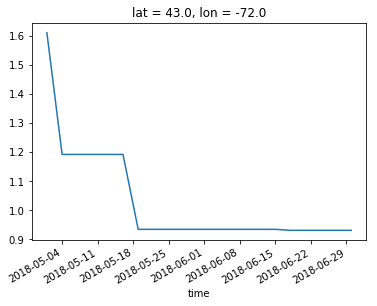

In [9]:
o.plot()

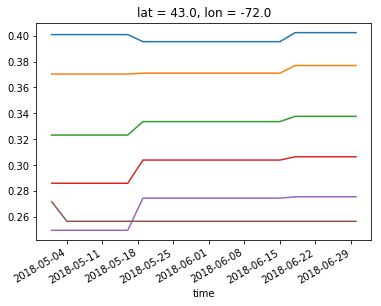

In [10]:
alg.A._output.plot()
alg.B._output.plot()
alg.C._output.plot()
alg.D._output.plot()
alg.E._output.plot()
alg.F._output.plot()

In [73]:
coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[43.0, 43.0], N[1], ctype['point']
	lon: ArrayCoordinates1d(lon): Bounds[-72.0, -72.0], N[1], ctype['point']
	time: UniformCoordinates1d(time): Bounds[2018-05-01, 2018-06-30], N[21], ctype['midpoint']

In [13]:
alg.F.sources[0].data.time

<xarray.DataArray 'time' (time: 10)>
array(['2018-04-30T13:00:00.000000000', '2018-04-30T16:00:00.000000000',
       '2018-04-30T19:00:00.000000000', '2018-04-30T22:00:00.000000000',
       '2018-05-01T01:00:00.000000000', '2018-05-01T04:00:00.000000000',
       '2018-05-01T07:00:00.000000000', '2018-05-01T10:00:00.000000000',
       '2018-05-01T13:00:00.000000000', '2018-05-01T16:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-04-30T13:00:00 ... 2018-05-01T16:00:00

In [25]:
alg.F.sources[0].native_coordinates.transform(coords.crs)

c:\repositories\pipeline\podpac\podpac\core\coordinates\dependent_coordinates.py:491: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")
c:\repositories\pipeline\podpac\podpac\core\coordinates\dependent_coordinates.py:493: UserWarning: transformation of coordinate segment lengths not yet implemented
  warnings.warn("transformation of coordinate segment lengths not yet implemented")


Coordinates (EPSG:4326)
	time: ArrayCoordinates1d(time): Bounds[2018-04-30T13:00:00.000000000, 2018-05-01T16:00:00.000000000], N[10], ctype['point']
	lat,lon[lat]: DependentCoordinates(i,j->lat): Bounds[-71.477134, -71.042828], shape(3, 4), ctype[midpoint]
	lat,lon[lon]: DependentCoordinates(i,j->lon): Bounds[51.675314, 51.955397], shape(3, 4), ctype[midpoint]

In [16]:
alg.F.sources[1].data[:, 2, 1]

<xarray.DataArray (time: 5)>
array([0.487714, 0.585689, 0.551034, 0.511558, 0.519669])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-02T11:59:59.999000 ... 2018-05-10T11:59:59.999000
    lat      float64 43.0
    lon      float64 -72.03
Attributes:
    crs:      EPSG:4326

In [17]:
alg.F._output

<xarray.UnitsDataArray (lat: 1, lon: 1, time: 21)>
array([[[0.487714, 0.585689, 0.511558, 0.519669, 0.519669, 0.519669,
         0.519669, 0.519669, 0.519669, 0.519669, 0.519669, 0.519669,
         0.519669, 0.519669, 0.519669, 0.519669, 0.519669, 0.519669,
         0.519669, 0.519669, 0.519669]]])
Coordinates:
  * lat      (lat) float64 43.0
  * lon      (lon) float64 -72.0
  * time     (time) datetime64[ns] 2018-05-01 2018-05-04 ... 2018-06-30
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x000001FFDF28D940>
    crs:          EPSG:4326

In [18]:
alg.F.sources[2]._output.time

<xarray.UnitsDataArray 'time' (time: 21)>
array(['2018-05-01T00:00:00.000000000', '2018-05-04T00:00:00.000000000',
       '2018-05-07T00:00:00.000000000', '2018-05-10T00:00:00.000000000',
       '2018-05-13T00:00:00.000000000', '2018-05-16T00:00:00.000000000',
       '2018-05-19T00:00:00.000000000', '2018-05-22T00:00:00.000000000',
       '2018-05-25T00:00:00.000000000', '2018-05-28T00:00:00.000000000',
       '2018-05-31T00:00:00.000000000', '2018-06-03T00:00:00.000000000',
       '2018-06-06T00:00:00.000000000', '2018-06-09T00:00:00.000000000',
       '2018-06-12T00:00:00.000000000', '2018-06-15T00:00:00.000000000',
       '2018-06-18T00:00:00.000000000', '2018-06-21T00:00:00.000000000',
       '2018-06-24T00:00:00.000000000', '2018-06-27T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-05-01 2018-05-04 ... 2018-06-30